# Introduction

The aim of this notebook is to introduce the driver class *PyVisa_Rigol_DP832A* utilizing the programmable DC power supply Rigol DP832A in my lab.

Sources (small selection):

- Basic functions for controlling test equipment with PyVisa: [https://github.com/freq0ut/Python-PyVisa](https://github.com/freq0ut/Python-PyVisa)
- Controlling a Rigol DP832 using PyVISA: [https://fixturfab.com/articles/controlling-rigol-dp832-using-pyvisa/](https://fixturfab.com/articles/controlling-rigol-dp832-using-pyvisa/)
- Controlling Rigol Dp832 with python: [https://juluribk.com/controlling-rigol-dp832-with-python.html](https://juluribk.com/controlling-rigol-dp832-with-python.html)
- Automating Test-Equipment with Python: [https://core-electronics.com.au/tutorials/automating-test-equipment-with-python.html](https://core-electronics.com.au/tutorials/automating-test-equipment-with-python.html)
- [DP800 Programming Manual, 2021-07-01](https://int.rigol.com/Images/DP800_ProgrammingGuide_EN_tcm7-3044.pdf)

## Installation of required Python libraries

In this application [PyVisa](https://pypi.org/project/PyVISA/) and [PyVISA-py](https://github.com/pyvisa/pyvisa-py) are used to communicate with the Rigol DP832A via LAN (TCP/IP) interface and SCPI commands. The communication over the USB device port does not work for me at the moment.

On Raspberry Pi both Python packages have to be installed first either via *pip* command or using *conda*.

Without conda, the installation is sensibly carried out in a Python *virtualenv* environment:
```
$ source ~/jupyter-env/bin/activate
$ pip install pyvisa pyvisa-py
```

## Load globally used libraries and set plot parameters

In [1]:
from IPython.display import Image

# Short technical overview of the Rigol DP832A

The Rigol DP832A is a very high quality programmable laboratory power supply with three switchable outputs (+30 V/3 A, +30 V/3 A and +5 V/3 A) and a maximum power output of 195 W.

Following documentation were helpful for further understanding (found [here](https://int.rigol.com/products/DP_detail/DP800)):

- [DP800 User Manual, 2016-06-03](https://int.rigol.com/Images/DP800_UserGuide_EN_tcm7-3049.pdf)
- [DP800 Programming Manual, 2021-07-01](https://int.rigol.com/Images/DP800_ProgrammingGuide_EN_tcm7-3044.pdf)

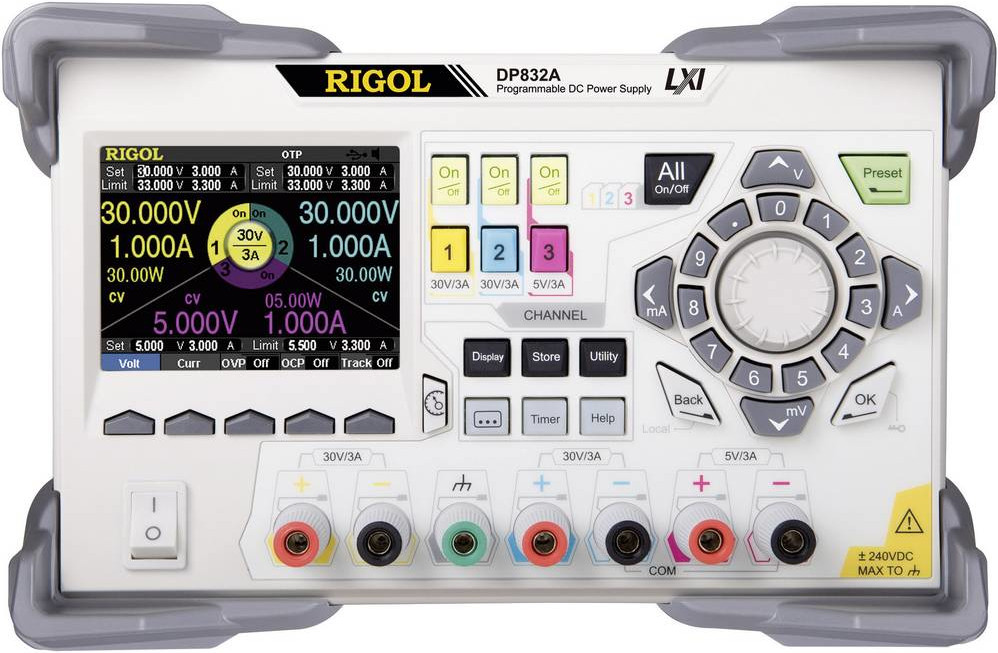

In [6]:
Image('images/rigol-dp832a-front.jpg', height=200)

# Remote control of the Rigol DP832A by SCPI commands

The device can be controlled remotely with SCPI commands through a variety of interfaces. The following interfaces are available:

- USB
- LAN
- GPIB (optional)

Control of the device can be integrated into your own applications, or by using LabView via these interfaces.

In this application [PyVisa](https://pypi.org/project/PyVISA/) and [PyVISA-py](https://github.com/pyvisa/pyvisa-py) are used to communicate with the Rigol DP832A via LAN (TCP/IP) interface and SCPI commands. The communication over the USB device port does not work for me at the moment.

## Using the wrapper class 'PyVisa_Rigol_DP832A' manually

The new wrapper class **PyVisa_Rigol_DP832A** in the python file *PyVisa_Rigol_DP832A_class.py* implements the communication with the Rigol DP832A via LAN interface and SCPI commands using PyVisa and PyVISA-py.

Separate class methods realize the basic control of the power supply, such as setting the current and voltage in the selected channel as well as setting and activating the overvoltage protection (OVP) and overcurrent protection (OCP). In addition, there are methods for measuring the actual values in the selected channel (current, voltage and power).

In [1]:
# import wrapper class PyVisa_Rigol_DP832A from python file PyVisa_Rigol_DP832A_class.py
from PyVisa_Rigol_DP832A_class import PyVisa_Rigol_DP832A

In [2]:
# create new device object for the power supply unit Rigol DP832A
psu = PyVisa_Rigol_DP832A(tcp_ip = '192.168.12.201')

In [3]:
# read connection state of the device
psu.status

'Connected'

In [4]:
# read connection path (at the moment there is only TCP/IP implemented; USB does not work for me)
psu.connected_with

'LAN over 192.168.12.201'

In [19]:
# toggle the output of channel 2 to OFF
psu.toggleOutput(2, 'OFF')

In [6]:
# set the voltage of channel 2 to 20 V
psu.setVoltage(2, 20)

In [7]:
# set the current of channel 2 to 0.8 A
psu.setCurrent(2, 0.8)

In [8]:
# toggle the output of channel 2 to ON
psu.toggleOutput(2, 'ON')

In [9]:
# set the overvoltage protection of channel 2 to 25 V
psu.setOVP(2, 25)

In [10]:
# set the overcurrent protection of channel 2 to 1.5 A
psu.setOCP(2, 1.5)

In [11]:
# activate overvoltage protection of channel 2
psu.toggleOVP(2, 'ON')

In [12]:
# activate overcurrent protection of channel 2
psu.toggleOCP(2, 'ON')

In [13]:
# measure the actual voltage of channel 2
psu.measVolt(2)

19.9991

In [14]:
# measure the actual current of channel 2
psu.measCurrent(2)

0.0008

In [15]:
# measure the actual power of channel 2
psu.measPower(2)

0.016

In [20]:
# close the connection to the device
psu.closeConnection()

In [18]:
# open the connection again
psu.openConnection('192.168.12.201')

## Automated use of the wrapper class 'PyVisa_Rigol_DP832A'

In this section, the wrapper class PyVisa_Rigol_DP832A is used to run through a voltage function curve. At the same time the actual voltage is measured.

For the simultaneous measurement of the actual voltage values, the voltage control function must be outsourced to a separate thread. The basic idea was found here: [https://github.com/nschloe/stressberry/blob/main/stressberry/cli/run.py](https://github.com/nschloe/stressberry/blob/main/stressberry/cli/run.py).